## Analisis con datos de Spotify


In [3]:
from glob import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Fuente
https://old.tacosdedatos.com/mas-data-viz-con-spotify-python

In [4]:

def read_history():
    history = []
    for file in sorted(glob("MyData/StreamingHistory0.json")):
        with open(file) as readable:
            history.extend(json.load(readable))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history

streaming_history = read_history()
streaming_history.head(5)

,endTime,artistName,trackName,msPlayed
0,2021-08-17 18:36:00,The Strokes,The Adults Are Talking,18800
1,2021-08-17 18:49:00,The Strokes,Brooklyn Bridge To Chorus,9880
2,2021-08-17 22:46:00,The Strokes,Brooklyn Bridge To Chorus,179645
3,2021-08-18 20:30:00,The Strokes,Selfless,54106
4,2021-08-18 20:43:00,Clairo,Bags,20760


In [6]:
print("Registros y observaciones")
print(streaming_history.shape)


Registros y observaciones
(4992, 4)


In [7]:
#streaming_history["artistName"].unique()
type(streaming_history)

pandas.core.frame.DataFrame

In [8]:
#Como no nos interesa la hora en que cada canción terminó, primero vamos a deshacernos de la parte temporal de endTime
streaming_history["date"] = streaming_history["endTime"].dt.floor('d')

In [9]:
streaming_history.head(5)

,endTime,artistName,trackName,msPlayed,date
0,2021-08-17 18:36:00,The Strokes,The Adults Are Talking,18800,2021-08-17
1,2021-08-17 18:49:00,The Strokes,Brooklyn Bridge To Chorus,9880,2021-08-17
2,2021-08-17 22:46:00,The Strokes,Brooklyn Bridge To Chorus,179645,2021-08-17
3,2021-08-18 20:30:00,The Strokes,Selfless,54106,2021-08-18
4,2021-08-18 20:43:00,Clairo,Bags,20760,2021-08-18


In [10]:
#Luego vamos a obtener un conteo de canciones por día con groupby
by_date = streaming_history.groupby("date")[["trackName"]].count()
by_date = by_date.sort_index()
by_date.head(4)

,trackName
date,
2021-08-17,3
2021-08-18,2
2021-08-20,1
2021-08-21,7


In [11]:
#necesitamos también saber a qué día de la semana y qué número de semana corresponde cada fecha, 
# esto lo obtenemos con las propiedades week y weekday:

by_date["weekday"] = by_date.index.weekday
by_date["week"] = by_date.index.week

/tmp/ipykernel_5147/2418181817.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  by_date["week"] = by_date.index.week


In [12]:
type(by_date)
by_date.head(4)

,trackName,weekday,week
date,,,
2021-08-17,3,1,33
2021-08-18,2,2,33
2021-08-20,1,4,33
2021-08-21,7,5,33


In [13]:
by_date["week"].unique()

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51,
       52,  1,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

In [14]:
#lo que falta es obtener números continuos para la semana, es decir, en el frame de arriba la semana 33 de 2021 debe 
# ser la semana 0, la semana 34 debe ser la semana 1. Esto lo haremos utilizando un ciclo for

week = 0
prev_week = by_date.iloc[0]["week"]
continuous_week = np.zeros(len(by_date)).astype(int)
sunday_dates = []
for i, (_, row) in enumerate(by_date.iterrows()):
    if row["week"] != prev_week:
        week += 1
        prev_week = row["week"]
    continuous_week[i] = week
by_date["continuous_week"] = continuous_week 
by_date.head()

,trackName,weekday,week,continuous_week
date,,,,
2021-08-17,3,1,33,0
2021-08-18,2,2,33,0
2021-08-20,1,4,33,0
2021-08-21,7,5,33,0
2021-08-22,1,6,33,0


In [15]:
#El siguiente paso es preparar, con NumPy, una matriz de tamaño días ✕ semanas en donde 
# cada una de las entradas será la cantidad de canciones que escuchamos en ese día, de esa semana:
songs = np.full((7, continuous_week.max()+1), np.nan)

for index, row in by_date.iterrows():
    songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

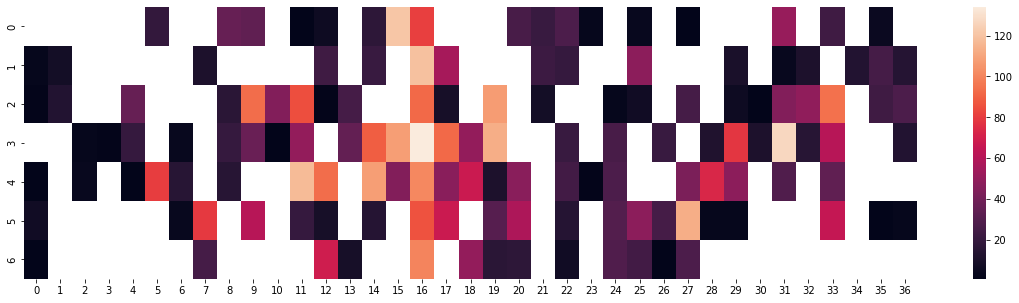

In [18]:
#Ahora, simplemente podríamos graficar el la matriz songs:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot()
mask = np.isnan(songs)
sns.heatmap(songs, ax = ax)
plt.show()

In [29]:
#Lo primero es limpiar un poco las etiquetas de los ejes:
from datetime import datetime, timedelta
import calendar

min_date = streaming_history["endTime"].min()
first_monday = min_date - timedelta(min_date.weekday())
mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
x_labels = [calendar.month_abbr[mons[0].month]]
x_labels.extend([
    calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
    for i in range(1, len(mons))])

y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

ValueError: The number of FixedLocator locations (37), usually from a call to set_ticks, does not match the number of ticklabels (36).

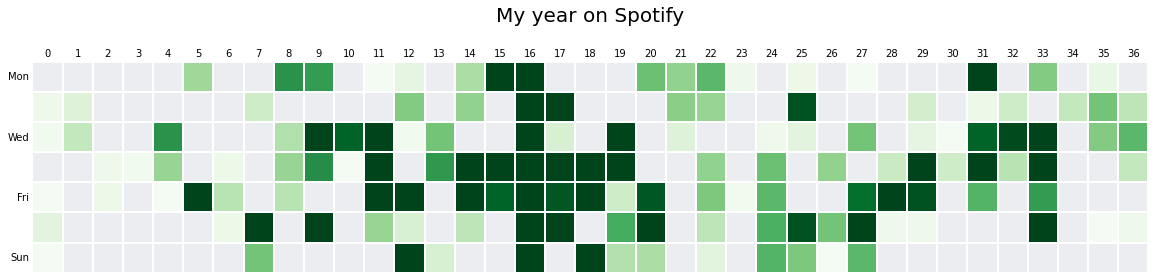

In [31]:
#Después vamos a hacer un poco de grafimagia con el tamaño de la gráfica, colores y los ejes:

fig = plt.figure(figsize=(20,5))
ax = plt.subplot()

ax.set_title("My year on Spotify", fontsize=20,pad=40)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both',length=0)
ax.set_facecolor("#ebedf0") 
fig.patch.set_facecolor('white')

sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            mask=np.isnan(songs), cmap="Greens",
            vmin=0, vmax=50, cbar=False, ax=ax)

ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, ha="left")
pass

In [33]:
ticklabels

NameError: name 'ticklabels' is not defined